In [1]:
import matplotlib.pyplot as plt
from dzdy import *

In [2]:

par_script = """ 
PCore pSIR{
    transmission_rate = 1.5/200
    rec_rate ~ triangle(0.1, 0.2, 0.3)
    beta ~ exp(transmission_rate)
    gamma ~ exp(rec_rate)
    Die ~ exp(0.2)
}
"""

dc_ctbn_script = '''
CTBN SIR_BN {
    life[Alive | Dead]
    sir[S | I | R]
    
    Alive{life:Alive}
    Dead{life:Dead}
    Inf{life:Alive, sir:I}
    Rec{life:Alive, sir:R}
    Sus{life:Alive, sir:S}

    Die -> Dead # from transition Die to state Dead by distribution Die
    Sus -- Infect_Net(beta) -> Inf
    Sus -- Infect(beta) -> Inf 
    Inf -- Recov(gamma) -> Rec
    
    Alive -- Die # from state Alive to transition Die
}
'''

da = Director()
da.read_pc(par_script)
da.read_dc(dc_ctbn_script)

In [3]:
pc = da.get_pc('pSIR')
pc = pc.sample_core()
pc.Locus

{'rec_rate': 0.25482866914676627, 'transmission_rate': 0.0075}

In [21]:
bp = da.get_dc("SIR_BN")
dc = bp.generate_model(pc)


sts = ['Inf', 'Rec']
sts = [dc[st] for st in sts]
to_check = list(sts)
checked = set()
reachables = set(sts)

while to_check:
    st = to_check.pop()
    for tr in st.next_transitions():
        st_new = st.exec(tr)
        reachables.add(st_new)
        if st_new not in checked:
            to_check.append(st_new)
    
    checked.add(st)

print(reachables)

{Inf, [life=Dead, sir=R], Rec, [life=Dead, sir=I]}


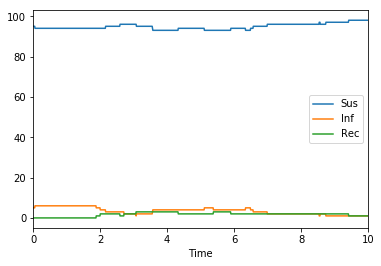

In [3]:
cfd = da.new_mc('ABM_M2', 'ABM', tar_pc='pSIR', tar_dc='SIR_BN')
cfd.add_behaviour('cycle', be_type='Reincarnation', s_birth = 'Sus', s_death = 'Dead')
cfd.add_behaviour('foi', be_type='ComFDShock', s_src='Inf', t_tar = 'Infect', dt=0.5)
cfd.add_behaviour('step', be_type='TimeStep', ts=[0.5, 4], ys=[1, 0.1, 5], t_tar = 'Infect')

cfd.set_observations(states=['Sus', 'Inf', 'Rec'])

mod, out = da.simulate('ABM_M2', y0={'Sus': 95, 'Inf': 5}, fr=0 ,to=10, dt=.01)
out.plot()
plt.show()

In [4]:
cfd = da.new_mc('ABM_M2', 'ABM', tar_pc='pSIR', tar_dc='SIR_BN')
cfd.add_network('IDU', 'BA', m=2)
cfd.add_behaviour('cycle', be_type='Reincarnation', s_birth = 'Sus', s_death = 'Dead')
cfd.add_behaviour('transmission', be_type='NetShock', s_src = 'Inf', t_tar = 'Infect_Net', net='IDU')
cfd.add_behaviour('foi', be_type='ForeignShock', t_tar = 'Infect')

cfd.set_observations(states=['Inf'], behaviours=['foi'])

cfd = da.new_mc('ABM_M5', 'ABM', tar_pc='pSIR', tar_dc='SIR_BN')
cfd.add_network('IDU', 'BA', m=5)
cfd.add_behaviour('cycle', be_type='Reincarnation', s_birth = 'Sus', s_death = 'Dead')
cfd.add_behaviour('transmission', be_type='NetShock', s_src = 'Inf', t_tar = 'Infect_Net', net='IDU')
cfd.add_behaviour('foi', be_type='ForeignShock', t_tar = 'Infect')

cfd.set_observations(states=['Inf'], behaviours=['foi'])

In [5]:
lyo = da.new_layout('Lyo1')

lyo.add_entry('A', 'ABM_M2', {'Sus': 20, 'Inf': 10})
lyo.add_entry('B', 'ABM_M2', {'Sus': 20}, size=3)
lyo.add_entry('C', 'ABM_M5', {'Sus': 20, 'Inf': 10}, size=2)
lyo.add_relation('*@Inf', 'Lyo1@FOI')
lyo.add_relation('Lyo1@FOI', '*@foi')
lyo.set_observations(['B_2', 'B_1', '*'])

dict_keys(['A', 'B_0', 'B_1', 'B_2', 'C_0', 'C_1'])
{'B_2', 'B_1'}


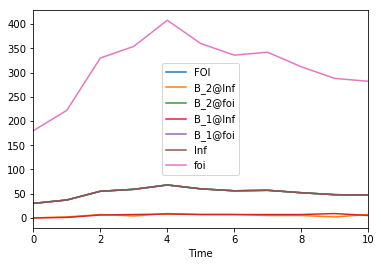

In [6]:
mod, out = da.simulate('Lyo1', fr=0, to=10)
out.plot()
plt.show()

In [ ]:
pc, dc = generate_pc_dc(da.get_pc('pSIR'), da.get_dc('SIR_BN'))
mc = CoreODE(dc)
mc.Mods['FOI'] = InfectionFD('FOI', 'Infect', 'Inf')
mc.Mods['Dead'] = Reincarnation('Dead', s_death='Dead', s_birth='Sus')
model = ODEModel('SIR', mc, dt=0.01)
model.add_obs_transition('Infect')
model.add_obs_state('Alive')
model.add_obs_state('Inf')
model.add_obs_state('Sus')   
model.add_obs_behaviour('Dead')

In [ ]:
cfd = da.new_mc('EBM', 'CoreODE', tar_pc='pSIR', tar_dc='SIR_BN')
cfd.add_behaviour('FOI', be_type='InfectionFD', s_src = 'Inf', t_tar = 'Infect')
cfd.add_behaviour('Dead', be_type='Reincarnation', s_death='Dead', s_birth='Sus')

cfd.set_observations(states=['Sus', 'Inf', 'Rec', 'Alive'], behaviours=['FOI'])


In [ ]:
mod, out = da.simulate('EBM', y0={'Sus': 95, 'Inf': 5}, fr=0 ,to=10, dt=.01)
#da.copy_model(mod_src=mod)
out.plot()
plt.show()

In [ ]:
out = simulate(model, y0={'Sus': 95, 'Inf': 5}, fr=0 ,to=10, dt=0.1)
out.plot()
plt.show()

In [11]:
mod.Obs.Obs